# Задача 2. Линейная регрессия, метод градиентного спуска

## Список задач
1. Самостоятельно реализовать функцию gradient_descent(X, y), которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал методом градиентного спуска (Batch Gradient Descent, GD) и возвращая вектор весов w. В качестве функционала можно выбрать, например, функцию ошибок MSE + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.
2. Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин тут (целевой признак для предсказания --- price).
3. Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).
4. Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
5. При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).
6. Случайным образом разбить данные на обучающую и тестовую выборки, используя методы существующих библиотек.
7. При обучении моделей использовать масштабирование данных.
8. Обучить модель на обучающей выборке, используя функцию gradient_descent(X, y). Оценить качество модели на обучающей и тестовой выборках, используя MSE, RMSE и $R^2$.
9. Обучить модель, используя существующую библиотеку. Например, в sklearn для $L_2$-регуляризатора можно использовать Ridge. Сравнить качество с Вашей реализацией.
10. Повторить тоже самое, но используя кросс-валидацию.
11. Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, E --- мат. ожидание и STD --- стандартное отклонение. Сделать выводы.
12. (+2 балла) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя Recursive Feature Elimination (RFE) из sklearn.
13. (+1 балл) Во все ваши реализации добавить возможность настройки нужных гиперпараметров, а в процессе обучения всех моделей осуществить подбор оптимальных значений этих гиперпараметров.
14. (+1 балл) Также самостоятельно реализовать метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD), обучить модели и добавить их во все сравнения.
15. (+1 балл) Также самостоятельно реализовать метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent), обучить модели и добавить их во все сравнения.

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.7 MB/s eta 0:00:00


In [2]:
RANDOM_STATE = 42

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFE, RFECV

from IPython.display import display
import time

import optuna

### 1. Реализация градиентного спуска
Самостоятельно реализовать функцию gradient_descent(X, y), которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал методом градиентного спуска (Batch Gradient Descent, GD) и возвращая вектор весов w. В качестве функционала можно выбрать, например, функцию ошибок MSE +  L2 -регуляризатор. Использовать матрично-векторные операции для вычисления градиента.

In [3]:
def MSE_L2_derivative(X: np.array, W: np.array, y: np.array, lambda_: float = 0.1) -> float:
    num_obj = X.shape[0]
    mse_derivative = (2/num_obj) * X.T @ (X @ W - y)
    l2_gradient = 2 * lambda_ * W
    l2_gradient[0] = 0
    return mse_derivative + l2_gradient

def gradient_descent(X: np.array, y:np.array, lr: float = 0.1, threshold:float = 0.001, lambda_: float = 0.1) -> np.array:
  # Добавляем в матрицу признаков единичный столбец смещения (bias)
  num_obj, num_features = X.shape[0], X.shape[1]
  X_bias = np.c_[np.ones((num_obj, 1)), X]
  W = np.random.randn(num_features + 1)

  iter = 0
  while True:
    change = lr* MSE_L2_derivative(X_bias,W,y, lambda_)
    W = W - change

    iter += 1
    if np.all(np.abs(change) < threshold) or (iter >= 1000):
      break

  return W

### 2. Загрузка и проверка данных
Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин тут (целевой признак для предсказания --- price).

In [4]:
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

In [5]:
print(X.shape)
print(y.shape)
display(X.tail(1))
display(y.head(1))

(20640, 8)
(20640,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24


,MedHouseVal
0,4.526


Данные загрузились корректно. Далее посмотрим описание датасета.

#### Набор данных о жилье в Калифорнии

**Характеристики набора данных:**

Количество экземпляров: 20640

Количество атрибутов: 8 числовых, прогнозные атрибуты и целевой объект

Информация об атрибутах:

- MedInc - Медианный доход в группе кварталов

- HouseAge - Медианный возраст домов в группе кварталов

- AveRooms - Среднее количество комнат в семье

- AveBedrms - Среднее количество спален в семье

- Population - Численность населения в группе кварталов

- AveOccup - Среднее количество членов семьи, проживающих в кварталах

- Latitude - Широта группы блоков

- Longitude - Долгота группы блоков

Целевой переменной является средняя стоимость дома для районов Калифорнии,
выраженная в сотнях тысяч долларов (100 000 долларов США).

Этот набор данных был получен на основе переписи населения США 1990 года с использованием одной строки для каждой
группы переписных блоков. Блочная группа - это наименьшая географическая единица, для которой США
Бюро переписи населения публикует выборочные данные (в квартальной группе, как правило, проживает
от 600 до 3000 человек).

Домохозяйство - это группа людей, проживающих в одном доме. Поскольку среднее
количество комнат и спальных комнат в этом наборе данных указано на домохозяйство, эти
столбцы могут принимать неожиданно большие значения для групп кварталов с небольшим количеством домохозяйств
и большим количеством пустующих домов, таких как курорты для отдыха.

### 3/4. Data cleaning. Разведочный анализ данных (EDA)

3. Выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).

4. Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


Нулевых значений нет

<Axes: >

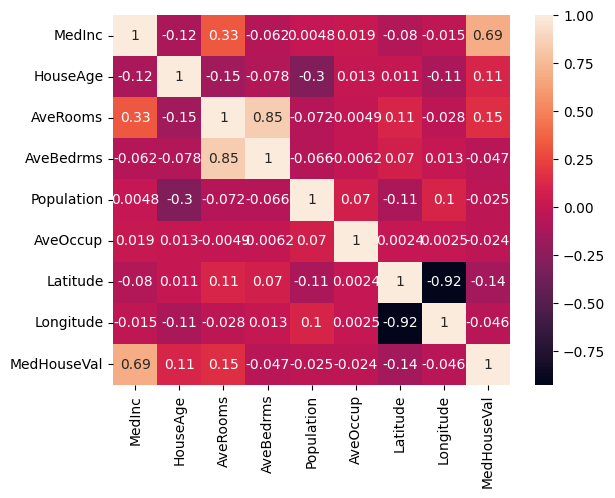

In [7]:
sns.heatmap(pd.concat([X, y], axis=1).corr(), annot=True)

AveRooms и AveBedrms имеют очень высокую корреляцию.
Давайте создадим новую переменную отношения количества спален к общему количеству комнат. А количество спален удалим, как малокореллирующую переменную с целевой.

С долготой и широтой требуется умная обработка путём смены значений на, допустим, признак региона или города. На пока просто понадеимся на $L_2$

In [8]:
X['BedroomsInRooms'] = X['AveBedrms']/X['AveRooms']
X = X.drop(columns=['AveBedrms'])

<Axes: >

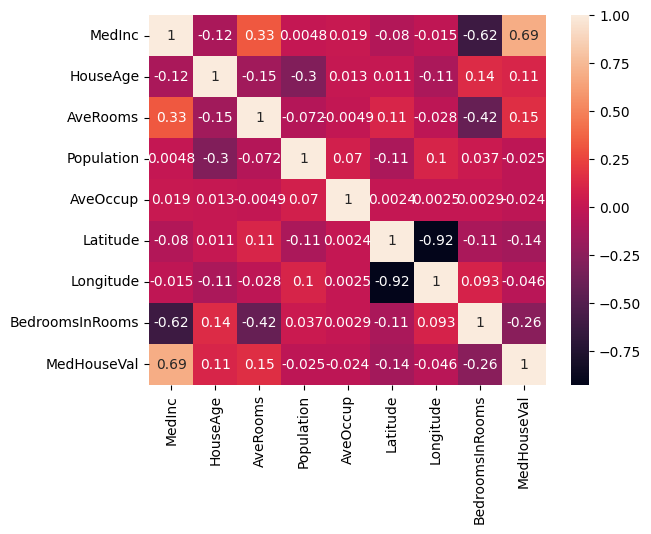

In [9]:
sns.heatmap(pd.concat([X, y], axis=1).corr(), annot=True)

Новая переменная имеет заметную корелляцию с медианным доходом, но также имеет некоторую связь с целевой переменной. Всё же оставлю.

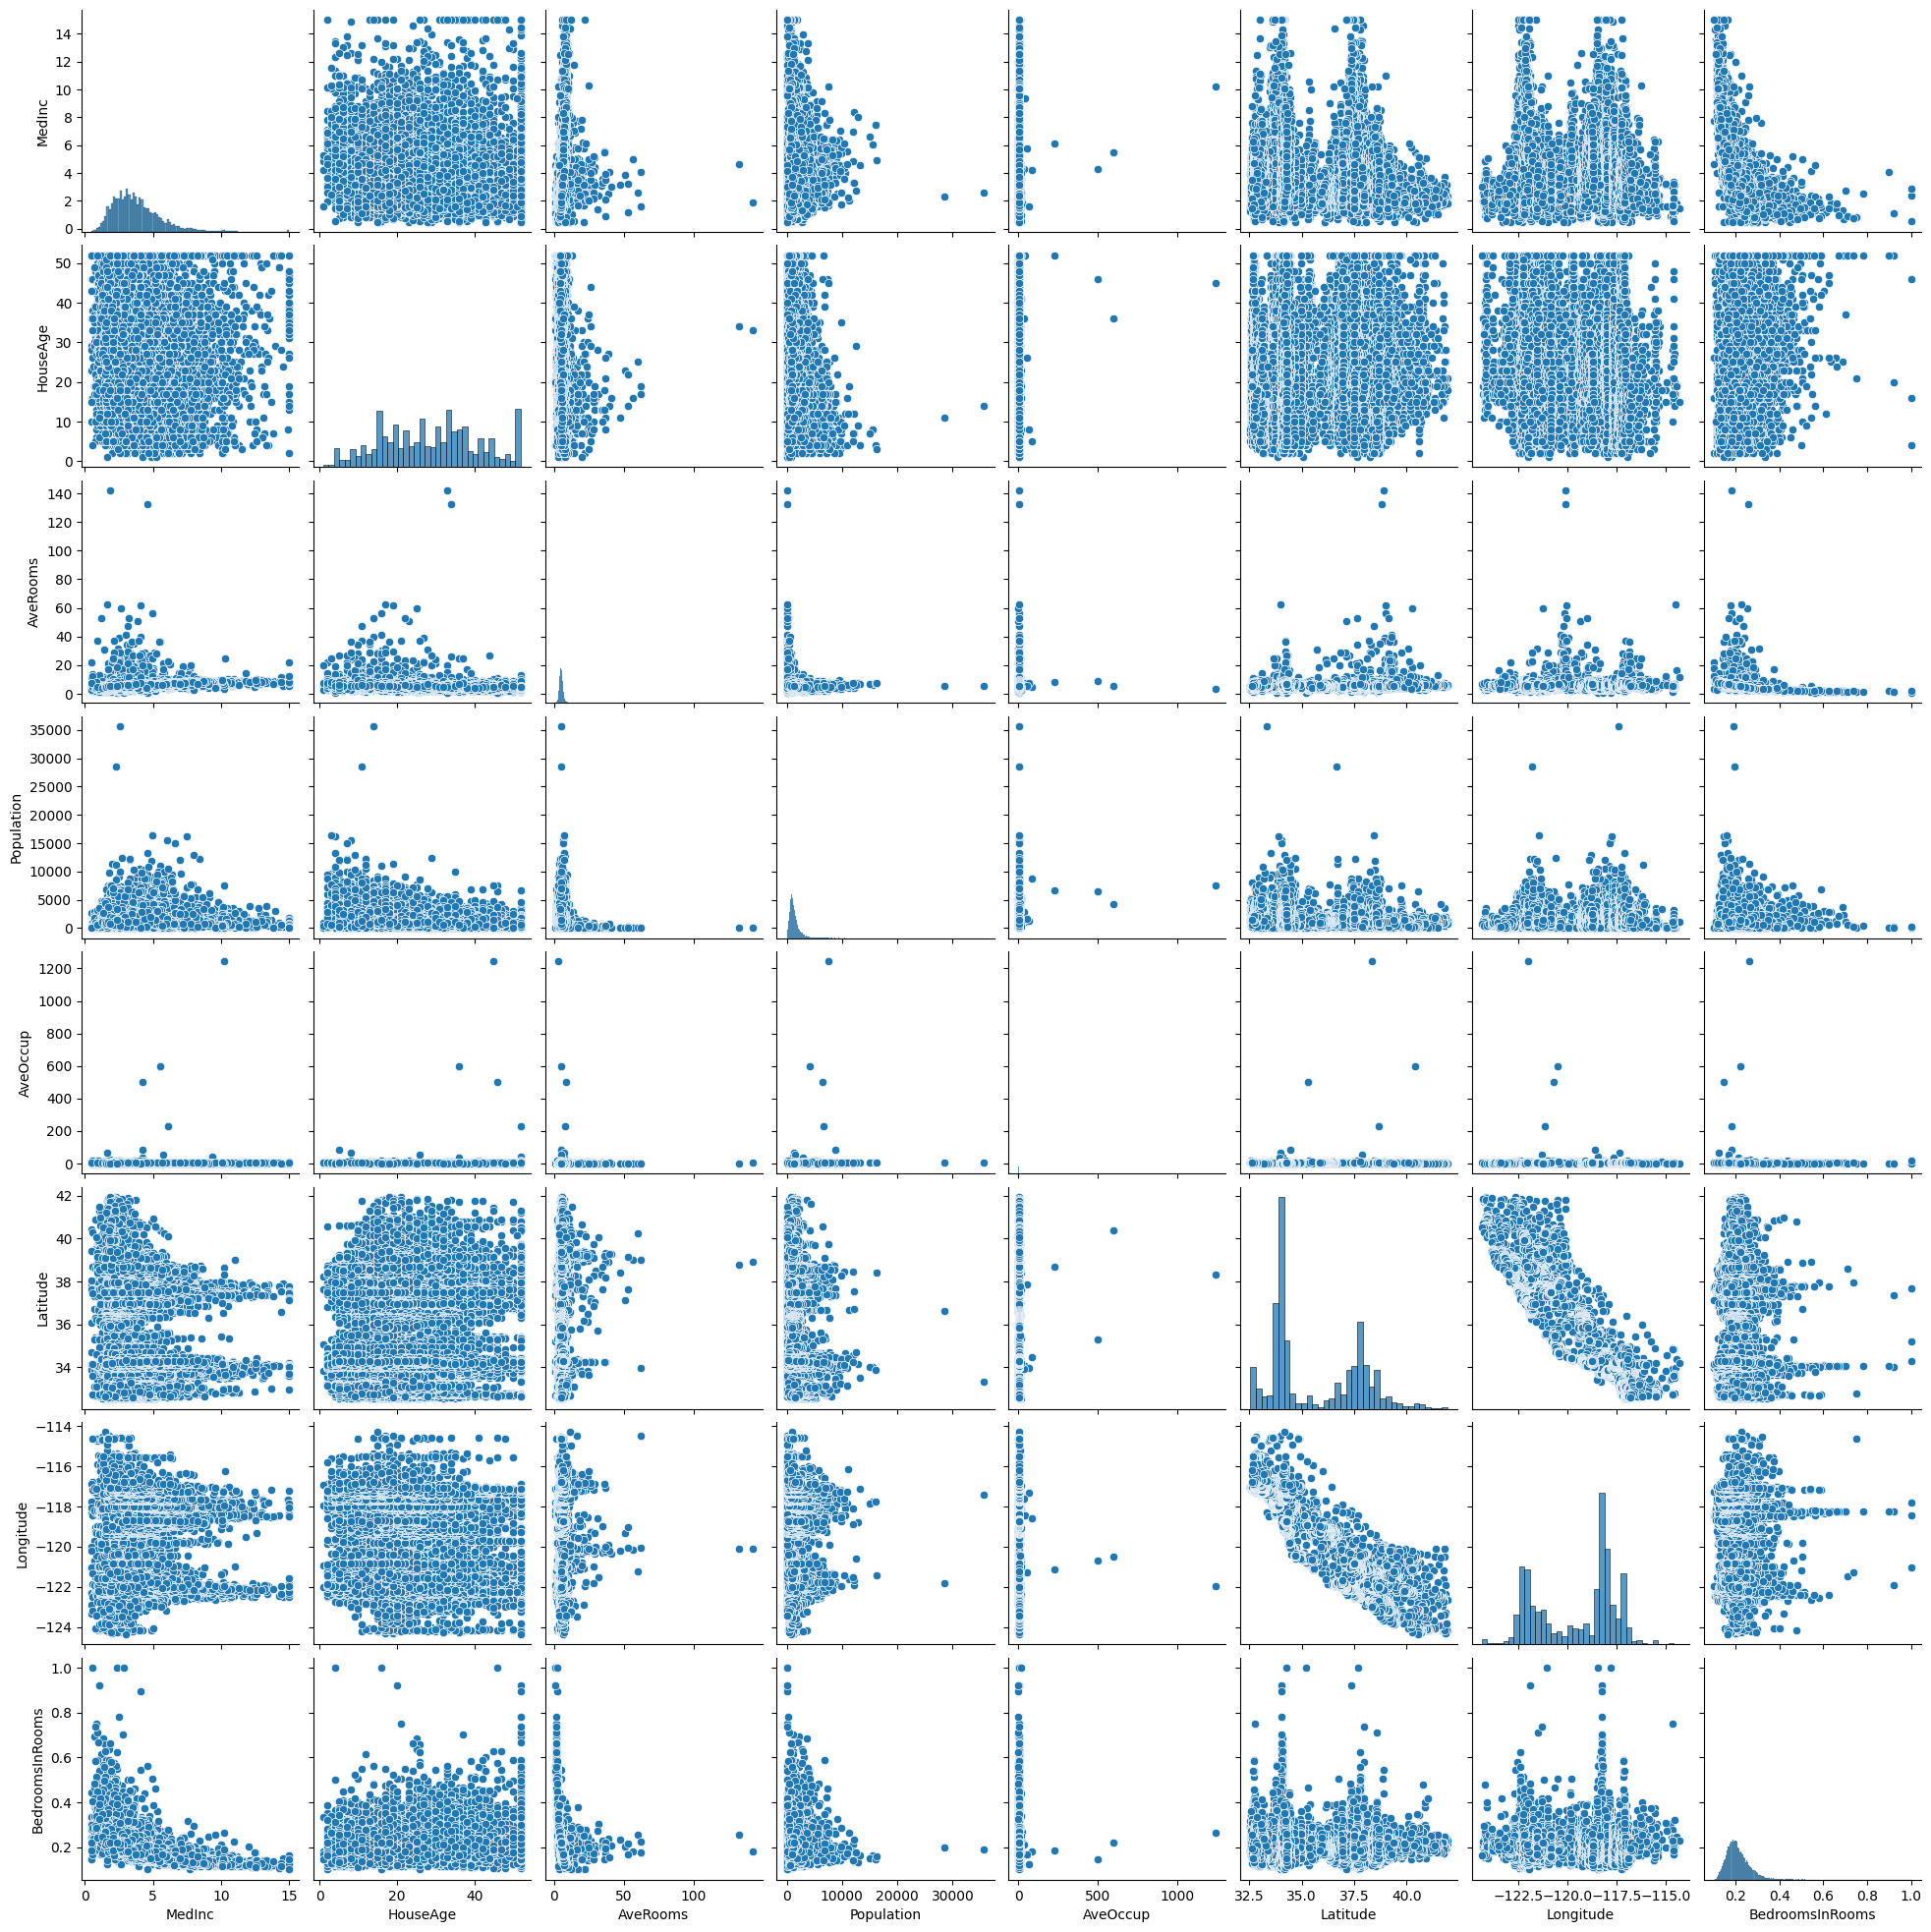

In [10]:
sns.pairplot(X)

У MedInc очевидная правосторонняя ассиметрия (понятно почему).
Предлагаю заменить её на логарифмическую шкалу, чтобы приблизить распределение признака к нормальному.

In [11]:
X['log_MedInc'] = np.log(X['MedInc'])
X = X.drop(columns=['MedInc'])

<Axes: xlabel='log_MedInc', ylabel='Count'>

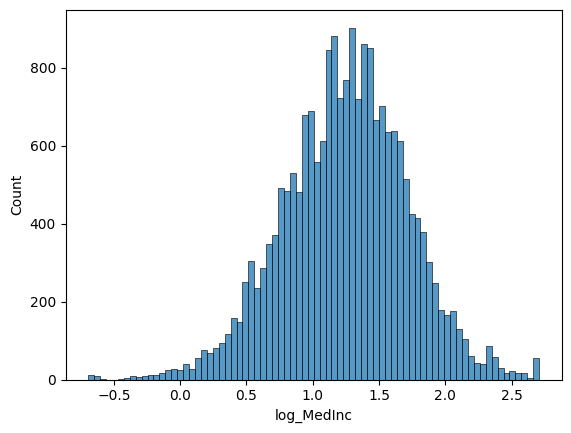

In [12]:
sns.histplot(data=X['log_MedInc'])

In [13]:
X.describe(percentiles=[.01, .05, .1, .25, .50, .75, .90, .95, .99])

,HouseAge,AveRooms,Population,AveOccup,Latitude,Longitude,BedroomsInRooms,log_MedInc
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,28.639486,5.429000,1425.476744,3.070655,35.631861,-119.569704,0.213075,1.244465
std,12.585558,2.474173,1132.462122,10.386050,2.135952,2.003532,0.058023,0.470653
min,1.000000,0.846154,3.000000,0.692308,32.540000,-124.350000,0.100000,-0.693347
1%,4.000000,2.581133,88.000000,1.536686,32.680000,-123.220000,0.124349,0.067313
5%,8.000000,3.432330,348.000000,1.872545,32.820000,-122.470000,0.141392,0.470360
10%,13.000000,3.790884,510.000000,2.075630,33.630000,-122.290000,0.153300,0.643852
25%,18.000000,4.440716,787.000000,2.429741,33.930000,-121.800000,0.175426,0.941334
50%,29.000000,5.229129,1166.000000,2.818116,34.260000,-118.490000,0.203181,1.262657
75%,37.000000,6.052381,1725.000000,3.282261,37.710000,-118.010000,0.239834,1.556723


Некорректных значений нет.

Выбросы:
AveRooms - видимо, те же богачи живут в домах (или дворцах :) ) со 141 комнатой.

Population - самые яркие "выбросы", где пара блоков отличается от медианы отличается в 3-35 раз. Скорее всего, это уже блоки не с частными домовладениями, а высокоплотной застройки.

AveOccup - аналогично Population.

Подводя итог, можно сказать, что "выбросы" это скорее всего отдельные когорты либо людей, либо блоков.
Стоит ли их выбрасывать от общей массы объектов? Определенно. Но тут, по хорошему, можно при помощи кластерного анализа выделить эти когорты и построить для них отдельные модели. Но пока можно попробовать два варианта (ради эксперимента): 1. оставить исходный датасет; 2. удалить "выбросы".
Далее построить линейную регрессию на обоих вариантах и посмотреть, спасёт ли $L_2$ регуляризация от выбросов.

In [14]:
X_original = X.copy()
X_changed = X.copy()

<Axes: ylabel='Population'>

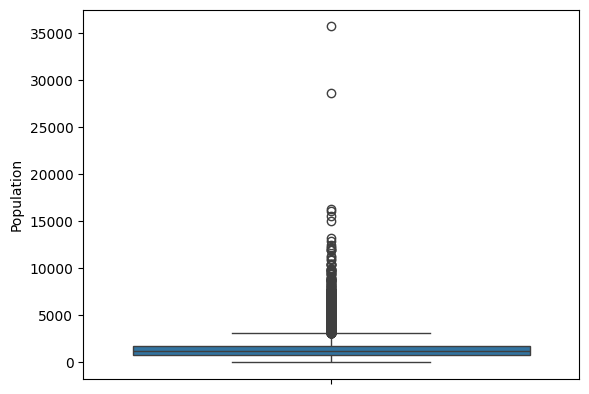

In [15]:
sns.boxplot(data=X_changed['Population'])

<Axes: xlabel='Population', ylabel='Count'>

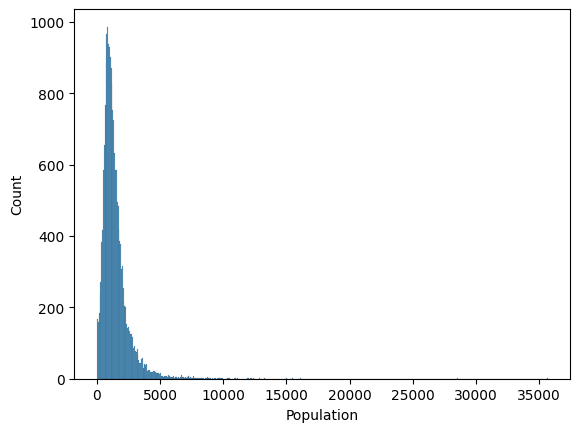

In [16]:
sns.histplot(data=X_changed['Population'])

Вопрос, где граница выбросов, тяжелый. Давайте выбросим данные, которые выходят за границу (75 перцентиля + 1.5 * межквартильный размах), как в ящике с усами.

limit = 3132.0


<Axes: >

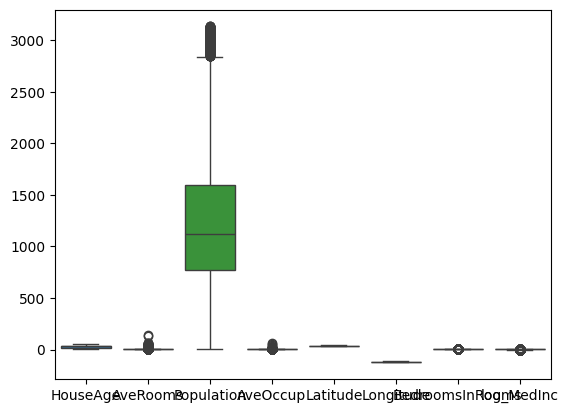

In [17]:
perc_75 = np.percentile(X_changed['Population'], 75)
perc_25 = np.percentile(X_changed['Population'], 25)
limit = perc_75 + 1.5*(perc_75-perc_25)
print(f'limit = {limit}')
X_changed = X_changed[X_changed['Population'] <= limit]
sns.boxplot(data=X_changed)

<Axes: >

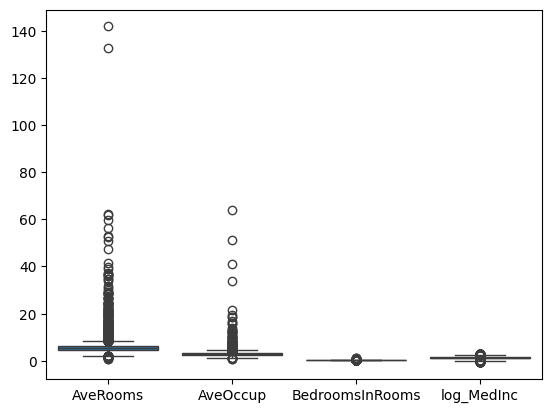

In [18]:
# выбрасываю все столбцы, к которым больше нет вопросов
sns.boxplot(data=X_changed.drop(columns=['Population', 'HouseAge', 'Latitude', 'Longitude']))

Применим ко всем оставшимся столбцам с выбросами такой же метод

In [19]:
cols = list(set(X_changed.columns) - set(['Population', 'HouseAge', 'Latitude', 'Longitude']))

for col in cols:
  perc_75 = np.percentile(X_changed[col], 75)
  perc_25 = np.percentile(X_changed[col], 25)
  upper_limit = perc_75 + 1.5*(perc_75-perc_25)
  down_limit = perc_25 - 1.5*(perc_75-perc_25)
  X_changed = X_changed[X_changed[col] <= upper_limit]
  X_changed = X_changed[X_changed[col] >= down_limit]

<Axes: >

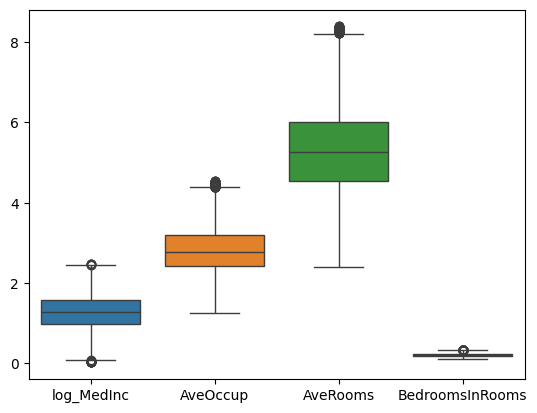

In [20]:
sns.boxplot(data=X_changed[cols])

Думаю, на это чистку данных можно закончить.

### 5.Transform data, Feature Engineering

При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).

Ранее уже были добавлены 2 новые переменные: отношение кол-ва спален к общему кол-ву комнат и логарифм медианного дохода в блоке.

Из каких-то новых осмысленных признаков можно добавить колонку RoomsPerPerson = AveRooms / AveOccup - т.е. количество комнат на человека

В остальном, пока не хочу пока плодить бессмысленных полиномиальных признаков и линейных комбинаций.

Ранее были убраны признаки: количество спален и медианный доход.

In [21]:
X_original['RoomsPerPerson'] = X_original['AveRooms']/X_original['AveOccup']
X_changed['RoomsPerPerson'] = X_changed['AveRooms']/X_changed['AveOccup']

In [22]:
columns = X_original.columns

### 6. Разбиение выборки

Случайным образом разбить данные на обучающую и тестовую выборки, используя методы существующих библиотек.

In [23]:
X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_original, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)
X_changed_train, X_changed_test, y_changed_train, y_changed_test = train_test_split(X_changed, y.loc[X_changed.index], test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

### 7. Масштабирование данных

При обучении моделей использовать масштабирование данных.

Применим широко распространенный StandardScaler, часто применяемый при работе с линейными моделями.

In [24]:
scaler1 = StandardScaler()
X_original_train_scaled = pd.DataFrame(scaler1.fit_transform(X_original_train), columns = X_original_train.columns, index=X_original_train.index)
X_original_test_scaled = pd.DataFrame(scaler1.transform(X_original_test), columns = X_original_test.columns, index=X_original_test.index)

scaler2 = StandardScaler()
X_changed_train_scaled = pd.DataFrame(scaler2.fit_transform(X_changed_train), columns = X_changed_train.columns, index=X_changed_train.index)
X_changed_test_scaled = pd.DataFrame(scaler2.transform(X_changed_test), columns = X_changed_test.columns, index=X_changed_test.index)

### 8. Проверка собственной имплементации модели

Обучить модель на обучающей выборке, используя функцию gradient_descent(X, y). Оценить качество модели на обучающей и тестовой выборках, используя MSE, RMSE и  $R_2$ .

In [25]:
W_original = gradient_descent(X_original_train_scaled, y_original_train,lr=0.1)
W_changed = gradient_descent(X_changed_train_scaled, y_changed_train,lr=0.1)

y_pred_original = np.c_[np.ones((X_original_test_scaled.shape[0], 1)), X_original_test_scaled] @ W_original
y_pred_changed = np.c_[np.ones((X_changed_test_scaled.shape[0], 1)), X_changed_test_scaled] @ W_changed

print(f'Датасет без удаления выбросов. MSE = {mean_squared_error(y_original_test, y_pred_original)}, RMSE = {root_mean_squared_error(y_original_test, y_pred_original)}, R2 = {r2_score(y_original_test, y_pred_original)}')
print(f'Датасет с удалением выбросов. MSE = {mean_squared_error(y_changed_test, y_pred_changed)}, RMSE = {root_mean_squared_error(y_changed_test, y_pred_changed)}, R2 = {r2_score(y_changed_test, y_pred_changed)}')

results = pd.DataFrame(columns=['Method', 'MSE', 'RMSE', 'R2'])
results.loc[len(results.index)] = {'Method': 'My_implementation. Default parameters', 'MSE': mean_squared_error(y_changed_test, y_pred_changed), 'RMSE' : (root_mean_squared_error(y_changed_test, y_pred_changed)), 'R2' : (r2_score(y_changed_test, y_pred_changed))}

Датасет без удаления выбросов. MSE = 0.5761592380976005, RMSE = 0.7590515384989353, R2 = 0.5603210542169514
Датасет с удалением выбросов. MSE = 0.464196686277857, RMSE = 0.6813198120397329, R2 = 0.6383633337333321


### 9. Использование LinearRegression + $L_2$ из Scikit-Learn

Обучить модель, используя существующую библиотеку. Например, в sklearn для  L2 -регуляризатора можно использовать Ridge. Сравнить качество с Вашей реализацией.

In [26]:
clf1 = Ridge(alpha=0.1, random_state=RANDOM_STATE)
clf1.fit(X_original_train_scaled, y_original_train)
y_pred_original = clf1.predict(X_original_test_scaled)

clf2 = Ridge(alpha=0.1, random_state=RANDOM_STATE)
clf2.fit(X_changed_train_scaled, y_changed_train)
y_pred_changed = clf2.predict(X_changed_test_scaled)

print(f'Датасет без удаления выбросов. MSE = {mean_squared_error(y_original_test, y_pred_original)}, RMSE = {root_mean_squared_error(y_original_test, y_pred_original)}, R2 = {r2_score(y_original_test, y_pred_original)}')
print(f'Датасет с удалением выбросов. MSE = {mean_squared_error(y_changed_test, y_pred_changed)}, RMSE = {root_mean_squared_error(y_changed_test, y_pred_changed)}, R2 = {r2_score(y_changed_test, y_pred_changed)}')

results.loc[len(results.index)] = {'Method': 'SKLearn Ridge. alpha=0.1', 'MSE': mean_squared_error(y_changed_test, y_pred_changed), 'RMSE' : (root_mean_squared_error(y_changed_test, y_pred_changed)), 'R2' : (r2_score(y_changed_test, y_pred_changed))}

Датасет без удаления выбросов. MSE = 0.5327339742183522, RMSE = 0.7298862748527007, R2 = 0.5934597648029722
Датасет с удалением выбросов. MSE = 0.42257479589607894, RMSE = 0.6500575327585082, R2 = 0.6707892474167684


Разница между собственной имплементацией и методом из Scikit-Learn заметна, но не фатальна. Вероятно это из-за того, что в библиотеку заложены более совершенные методы оптимизации, чем обычный градиентный спуск.

Датасет с удаленными выбросами показал себя лучше. Дальше будем пользоваться только им.

In [27]:
X_train_scaled, X_test_scaled, y_train, y_test = X_changed_train_scaled, X_changed_test_scaled, y_changed_train, y_changed_test

### 10/11. Ridge + CrossValidation / Изучение результатов CrossValidation

10. Повторить тоже самое, но используя кросс-валидацию.

11. Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, $\sigma$), где k - количество фолдов в кросс-валидации, E - мат. ожидание и $\sigma$ - стандартное отклонение. Сделать выводы.

In [28]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
X = pd.concat([X_train_scaled, X_test_scaled], axis=0)
y = pd.concat([y_train, y_test], axis=0)

cv_results = pd.DataFrame(columns=['Method', 'Fold', 'MSE_Train', 'MSE_Test',
                                   'RMSE_Train', 'RMSE_Test', 'R2_Train', 'R2_Test',
                                   'MSE_Mean', 'MSE_STD', 'RMSE_Mean', 'RMSE_STD',
                                   'R2_Mean', 'R2_STD'])


iter = 1
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    W = gradient_descent(X_train_kf, y_train_kf)

    y_pred_train = np.c_[np.ones((X_train_kf.shape[0], 1)), X_train_kf] @ W
    y_pred_test = np.c_[np.ones((X_test_kf.shape[0], 1)), X_test_kf] @ W

    cv_results.loc[len(cv_results.index)] = {
        'Method': 'CV. My impl.', 'Fold': f'Fold{iter}',
        'MSE_Train': mean_squared_error(y_train_kf, y_pred_train),
        'MSE_Test': mean_squared_error(y_test_kf, y_pred_test),
        'RMSE_Train': np.sqrt(mean_squared_error(y_train_kf, y_pred_train)),
        'RMSE_Test': np.sqrt(mean_squared_error(y_test_kf, y_pred_test)),
        'R2_Train': r2_score(y_train_kf, y_pred_train),
        'R2_Test': r2_score(y_test_kf, y_pred_test)}

    clf = Ridge(alpha=0.1, random_state=RANDOM_STATE)
    clf.fit(X_train_kf, y_train_kf)
    y_pred_train_ridge = clf.predict(X_train_kf)
    y_pred_test_ridge = clf.predict(X_test_kf)

    cv_results.loc[len(cv_results.index)] = {
        'Method': 'CV. SKLearn Ridge', 'Fold': f'Fold{iter}',
        'MSE_Train': mean_squared_error(y_train_kf, y_pred_train_ridge),
        'MSE_Test': mean_squared_error(y_test_kf, y_pred_test_ridge),
        'RMSE_Train': np.sqrt(mean_squared_error(y_train_kf, y_pred_train_ridge)),
        'RMSE_Test': np.sqrt(mean_squared_error(y_test_kf, y_pred_test_ridge)),
        'R2_Train': r2_score(y_train_kf, y_pred_train_ridge),
        'R2_Test': r2_score(y_test_kf, y_pred_test_ridge)}

    iter += 1

for method in cv_results['Method'].unique():
    method_results = cv_results[cv_results['Method'] == method]

    mse_mean = method_results['MSE_Test'].mean()
    mse_std = method_results['MSE_Test'].std()
    rmse_mean = method_results['RMSE_Test'].mean()
    rmse_std = method_results['RMSE_Test'].std()
    r2_mean = method_results['R2_Test'].mean()
    r2_std = method_results['R2_Test'].std()

    cv_results.loc[len(cv_results.index)] = {
        'Method': method,
        'Fold': 'Overall',
        'MSE_Mean': mse_mean,
        'MSE_STD': mse_std,
        'RMSE_Mean': rmse_mean,
        'RMSE_STD': rmse_std,
        'R2_Mean': r2_mean,
        'R2_STD': r2_std}

    results.loc[len(results.index)] = {
        'Method': method,
        'MSE': mse_mean,
        'RMSE': rmse_mean,
        'R2': r2_mean
    }

print("Cross-validation results (with E and STD):")
display(cv_results)
print("\nFinal averaged results:")
display(results)

Cross-validation results (with E and STD):


,Method,Fold,MSE_Train,MSE_Test,RMSE_Train,RMSE_Test,R2_Train,R2_Test,MSE_Mean,MSE_STD,RMSE_Mean,RMSE_STD,R2_Mean,R2_STD
0,CV. My impl.,Fold1,0.477080,0.497352,0.690710,0.705232,0.632257,0.638361,NaN,NaN,NaN,NaN,NaN,NaN
1,CV. SKLearn Ridge,Fold1,0.437423,0.459635,0.661380,0.677964,0.662824,0.665786,NaN,NaN,NaN,NaN,NaN,NaN
2,CV. My impl.,Fold2,0.485600,0.488230,0.696850,0.698735,0.630921,0.625052,NaN,NaN,NaN,NaN,NaN,NaN
3,CV. SKLearn Ridge,Fold2,0.441972,0.441509,0.664810,0.664461,0.664081,0.660932,NaN,NaN,NaN,NaN,NaN,NaN
4,CV. My impl.,Fold3,0.487931,0.480124,0.698520,0.692910,0.629615,0.629395,NaN,NaN,NaN,NaN,NaN,NaN
5,CV. SKLearn Ridge,Fold3,0.443540,0.435224,0.665988,0.659715,0.663312,0.664053,NaN,NaN,NaN,NaN,NaN,NaN
6,CV. My impl.,Fold4,0.485014,0.475509,0.696429,0.689571,0.630694,0.637534,NaN,NaN,NaN,NaN,NaN,NaN
7,CV. SKLearn Ridge,Fold4,0.442608,0.439200,0.665288,0.662722,0.662984,0.665211,NaN,NaN,NaN,NaN,NaN,NaN
8,CV. My impl.,Fold5,0.486246,0.484473,0.697313,0.696041,0.632009,0.621269,NaN,NaN,NaN,NaN,NaN,NaN
9,CV. SKLearn Ridge,Fold5,0.443191,0.436615,0.665726,0.660768,0.664593,0.658681,NaN,NaN,NaN,NaN,NaN,NaN



Final averaged results:


,Method,MSE,RMSE,R2
0,My_implementation. Default parameters,0.464197,0.681320,0.638363
1,SKLearn Ridge. alpha=0.1,0.422575,0.650058,0.670789
2,CV. My impl.,0.485137,0.696498,0.630322
3,CV. SKLearn Ridge,0.442437,0.665126,0.662933


Ridge вновь показывает себя лучше по метрикам (MSE, RMSE) и лучше объясняет дисперсию ($R^2$), чем моя имплементация.
Однако, что интересно, именно у моей имплементации стандартное отклоненеие меньше, чем у Ridge, при более высокой ошибке, что говорит о некотором "неправильном" смещении ответов моего метода, и возможно если добавить оптимизацию Bias, результаты будут лучше.

CV очевидно показал худшие результаты, чем прошлый запуск на всех данных, но эти результаты надёжнее.

### 12. Подбор лучших признаков с помощью метода RFE

(+2 балла) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя Recursive Feature Elimination (RFE) из sklearn.


In [29]:
clf = Ridge(alpha=0.1)
cv = KFold(n_splits=25, shuffle=True, random_state=RANDOM_STATE)

rfecv = RFECV(estimator=clf, scoring='r2', cv=cv, min_features_to_select = 1, step=1)
rfecv.fit(X, y)

RFECV(cv=KFold(n_splits=25, random_state=42, shuffle=True),
      estimator=Ridge(alpha=0.1), scoring='r2')

In [30]:
print(f"Optimal number of features: {rfecv.n_features_}")
display(pd.DataFrame(rfecv.support_,index=X.columns,columns=['Rank']))

Optimal number of features: 8


,Rank
HouseAge,True
AveRooms,True
Population,True
AveOccup,False
Latitude,True
Longitude,True
BedroomsInRooms,True
log_MedInc,True
RoomsPerPerson,True


In [31]:
columns_rfe = list(set(X.columns) - set(['AveOccup']))

По итогу рекурсивного отбора признаков аж на 25 фолдах, предложено было убрать лишь один признак - AveOccup. Хотелось бы отметить, что это признак, с самой низкой корреляцией по модулю с целевой переменной.

In [32]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
X = X[columns_rfe]

cv_results = pd.DataFrame(columns=['Method', 'Fold', 'MSE_Train', 'MSE_Test',
                                   'RMSE_Train', 'RMSE_Test', 'R2_Train', 'R2_Test',
                                   'MSE_Mean', 'MSE_STD', 'RMSE_Mean', 'RMSE_STD',
                                   'R2_Mean', 'R2_STD'])


iter = 1
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    W = gradient_descent(X_train_kf, y_train_kf)

    y_pred_train = np.c_[np.ones((X_train_kf.shape[0], 1)), X_train_kf] @ W
    y_pred_test = np.c_[np.ones((X_test_kf.shape[0], 1)), X_test_kf] @ W

    cv_results.loc[len(cv_results.index)] = {
        'Method': 'CV. My impl. After RFE', 'Fold': f'Fold{iter}',
        'MSE_Train': mean_squared_error(y_train_kf, y_pred_train),
        'MSE_Test': mean_squared_error(y_test_kf, y_pred_test),
        'RMSE_Train': np.sqrt(mean_squared_error(y_train_kf, y_pred_train)),
        'RMSE_Test': np.sqrt(mean_squared_error(y_test_kf, y_pred_test)),
        'R2_Train': r2_score(y_train_kf, y_pred_train),
        'R2_Test': r2_score(y_test_kf, y_pred_test)}

    clf = Ridge(alpha=0.1, random_state=RANDOM_STATE)
    clf.fit(X_train_kf, y_train_kf)
    y_pred_train_ridge = clf.predict(X_train_kf)
    y_pred_test_ridge = clf.predict(X_test_kf)

    cv_results.loc[len(cv_results.index)] = {
        'Method': 'CV. SKLearn Ridge after RFE', 'Fold': f'Fold{iter}',
        'MSE_Train': mean_squared_error(y_train_kf, y_pred_train_ridge),
        'MSE_Test': mean_squared_error(y_test_kf, y_pred_test_ridge),
        'RMSE_Train': np.sqrt(mean_squared_error(y_train_kf, y_pred_train_ridge)),
        'RMSE_Test': np.sqrt(mean_squared_error(y_test_kf, y_pred_test_ridge)),
        'R2_Train': r2_score(y_train_kf, y_pred_train_ridge),
        'R2_Test': r2_score(y_test_kf, y_pred_test_ridge)}

    iter += 1

for method in cv_results['Method'].unique():
    method_results = cv_results[cv_results['Method'] == method]

    mse_mean = method_results['MSE_Test'].mean()
    mse_std = method_results['MSE_Test'].std()
    rmse_mean = method_results['RMSE_Test'].mean()
    rmse_std = method_results['RMSE_Test'].std()
    r2_mean = method_results['R2_Test'].mean()
    r2_std = method_results['R2_Test'].std()

    cv_results.loc[len(cv_results.index)] = {
        'Method': method,
        'Fold': 'Overall',
        'MSE_Mean': mse_mean,
        'MSE_STD': mse_std,
        'RMSE_Mean': rmse_mean,
        'RMSE_STD': rmse_std,
        'R2_Mean': r2_mean,
        'R2_STD': r2_std}

    results.loc[len(results.index)] = {
        'Method': method,
        'MSE': mse_mean,
        'RMSE': rmse_mean,
        'R2': r2_mean
    }

print("Cross-validation results (with E and STD):")
display(cv_results)
print("\nFinal averaged results:")
display(results)

Cross-validation results (with E and STD):


,Method,Fold,MSE_Train,MSE_Test,RMSE_Train,RMSE_Test,R2_Train,R2_Test,MSE_Mean,MSE_STD,RMSE_Mean,RMSE_STD,R2_Mean,R2_STD
0,CV. My impl. After RFE,Fold1,0.481090,0.499989,0.693607,0.707099,0.629165,0.636443,NaN,NaN,NaN,NaN,NaN,NaN
1,CV. SKLearn Ridge after RFE,Fold1,0.437424,0.459645,0.661380,0.677971,0.662824,0.665778,NaN,NaN,NaN,NaN,NaN,NaN
2,CV. My impl. After RFE,Fold2,0.480235,0.483132,0.692990,0.695077,0.634999,0.628967,NaN,NaN,NaN,NaN,NaN,NaN
3,CV. SKLearn Ridge after RFE,Fold2,0.441972,0.441514,0.664810,0.664465,0.664081,0.660928,NaN,NaN,NaN,NaN,NaN,NaN
4,CV. My impl. After RFE,Fold3,0.486118,0.479428,0.697222,0.692407,0.630991,0.629932,NaN,NaN,NaN,NaN,NaN,NaN
5,CV. SKLearn Ridge after RFE,Fold3,0.443568,0.435094,0.666009,0.659617,0.663291,0.664153,NaN,NaN,NaN,NaN,NaN,NaN
6,CV. My impl. After RFE,Fold4,0.483317,0.473375,0.695210,0.688022,0.631987,0.639161,NaN,NaN,NaN,NaN,NaN,NaN
7,CV. SKLearn Ridge after RFE,Fold4,0.442618,0.439180,0.665296,0.662707,0.662976,0.665226,NaN,NaN,NaN,NaN,NaN,NaN
8,CV. My impl. After RFE,Fold5,0.485706,0.483592,0.696926,0.695408,0.632418,0.621957,NaN,NaN,NaN,NaN,NaN,NaN
9,CV. SKLearn Ridge after RFE,Fold5,0.443196,0.436622,0.665730,0.660774,0.664589,0.658676,NaN,NaN,NaN,NaN,NaN,NaN



Final averaged results:


,Method,MSE,RMSE,R2
0,My_implementation. Default parameters,0.464197,0.681320,0.638363
1,SKLearn Ridge. alpha=0.1,0.422575,0.650058,0.670789
2,CV. My impl.,0.485137,0.696498,0.630322
3,CV. SKLearn Ridge,0.442437,0.665126,0.662933
4,CV. My impl. After RFE,0.483903,0.695603,0.631292
5,CV. SKLearn Ridge after RFE,0.442411,0.665107,0.662952


Качество после подбора признаков стало лучше, но честности ради, улучшение в пределах погрешности (4-5 знак после запятой в MSE)

### 13. Подбор оптимальных гиперпараметров в собственной имплементации

(+1 балл) Во все ваши реализации добавить возможность настройки нужных гиперпараметров, а в процессе обучения всех моделей осуществить подбор оптимальных значений этих гиперпараметров.

Для начала, допишу свой метод, обернув всё в класс и реализовав интерфейс для взаимодействия собственного метода с алгоритмами из Scikit-Learn.

In [33]:
class MyLinReg:
    def __init__(self, lambda_: float = 0.1, lr: float = 0.1):
        self.lambda_ = lambda_
        self.lr = lr

    def MSE_L2_derivative(self, X: np.array, W: np.array, y: np.array) -> np.array:
        mse_derivative = (2 / self.num_obj) * X.T @ (X @ W - y)
        l2_gradient = 2 * self.lambda_ * W
        l2_gradient[0] = 0  # исключаем регуляризацию для смещения
        return mse_derivative + l2_gradient

    def gradient_descent(self, X: np.array, y: np.array, threshold: float = 0.001):
        self.num_obj, self.num_features = X.shape
        X_bias = np.c_[np.ones((self.num_obj, 1)), X]  # добавляем столбец единиц для смещения
        self.W = np.random.randn(self.num_features + 1)  # инициализация весов
        iter = 0

        while True:
            change = self.lr * self.MSE_L2_derivative(X_bias, self.W, y)
            self.W -= change

            iter += 1
            if np.all(np.abs(change) < threshold) or (iter >= 1000):
                break

    def fit(self, X: np.array, y: np.array):
        self.gradient_descent(X, y)  # Инициализация `self.W` происходит внутри gradient_descent
        return self

    def predict(self, X: np.array) -> np.array:
        X_bias = np.c_[np.ones((X.shape[0], 1)), X]  # добавляем единичный столбец, но не транспонируем
        return X_bias @ self.W  # предсказания

    def get_params(self, deep=True) -> dict:
        # Возвращает параметры модели в виде словаря
        return {"lambda_": self.lambda_, "lr": self.lr}

    def set_params(self, **params):
        # Устанавливает параметры из словаря
        for param, value in params.items():
            setattr(self, param, value)
        return self

Применим GridSearchCV. Конечно, в любом другом случае это - непозволительная роскошь. Но так как у нас и метод - лёгкий, и объектов - мало. Могу себе позволить.

In [34]:
parameters = {'lr': np.arange(0.0, 0.25, 0.01), 'lambda_': np.arange(0.0, 1.1, 0.1)}

my_linReg = MyLinReg()

clf = GridSearchCV(my_linReg, parameters, scoring='neg_mean_squared_error', cv=5)
clf.fit(X_train_scaled[columns_rfe], y_train)

GridSearchCV(cv=5, estimator=<__main__.MyLinReg object at 0x7d8f22d42320>,
             param_grid={'lambda_': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'lr': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24])},
             scoring='neg_mean_squared_error')

In [35]:
clf.best_params_

{'lambda_': 0.0, 'lr': 0.15}

In [36]:
best_params = clf.best_params_
clf = MyLinReg(**best_params)

start = time.time()
clf.fit(X_train_scaled[columns_rfe], y_train)
end = time.time()
print(f'Время выполнения = {end - start}')
y_pred = clf.predict(X_test_scaled[columns_rfe])

results.loc[len(results.index)] = {'Method': f'My_implementation. RFE. GridSearchCV. {best_params}', 'MSE': mean_squared_error(y_test, y_pred), 'RMSE' : (root_mean_squared_error(y_test, y_pred)), 'R2' : (r2_score(y_test, y_pred))}

Время выполнения = 0.13656115531921387


In [ ]:
parameters = {'alpha': np.arange(0.0, 1.1, 0.1),
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']}

linReg = Ridge()

clf = GridSearchCV(linReg, parameters, scoring='neg_mean_squared_error', cv=5)
clf.fit(X_train_scaled[columns_rfe], y_train)
clf.best_params_

In [38]:
best_params = clf.best_params_
start = time.time()
clf = Ridge(**best_params).fit(X_train_scaled[columns_rfe], y_train)
end = time.time()
print(f'Время выполнения = {end - start}')
y_pred = clf.predict(X_test_scaled[columns_rfe])

results.loc[len(results.index)] = {f'Method': f'SKLearn Ridge. RFE. GridSearchCV. {best_params}', 'MSE': mean_squared_error(y_test, y_pred), 'RMSE' : (root_mean_squared_error(y_test, y_pred)), 'R2' : (r2_score(y_test, y_pred))}

Время выполнения = 0.17121267318725586


In [39]:
results

,Method,MSE,RMSE,R2
0,My_implementation. Default parameters,0.464197,0.681320,0.638363
1,SKLearn Ridge. alpha=0.1,0.422575,0.650058,0.670789
2,CV. My impl.,0.485137,0.696498,0.630322
3,CV. SKLearn Ridge,0.442437,0.665126,0.662933
4,CV. My impl. After RFE,0.483903,0.695603,0.631292
5,CV. SKLearn Ridge after RFE,0.442411,0.665107,0.662952
6,My_implementation. RFE. GridSearchCV. {'lambda...,0.422665,0.650127,0.670719
7,SKLearn Ridge. RFE. GridSearchCV. {'alpha': 0....,0.422584,0.650064,0.670782


Возникла интересная ситуация, что после подбора гиперпараметров по сетке, качество моей имплементации и метода из Scikit-Learn сравнялись. На самом деле, это странно. Я не был уверен, что обычным градиентным спуском получиться добиться сходных результатов в поиске глобального минимума по сравнении с более совершенными методами из Scikit-Learn. Это получилось.

Но библиотечный метод в 1.5-2 раза быстрее :)

### 14. Реализация стохастического градиентного спуска

(+1 балл) Также самостоятельно реализовать метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD), обучить модели и добавить их во все сравнения.


In [40]:
class MyLinRegSGD:
    def __init__(self, lambda_: float = 0.1, lr: float = 0.05, n_epochs: int = 100):
        self.lambda_ = lambda_
        self.lr = lr
        self.n_epochs = n_epochs

    def MSE_L2_derivative(self, X_i: np.array, W: np.array, y_i: float) -> np.array:
        if X_i.ndim == 1:
          X_i = X_i.reshape(1, -1)
        mse_derivative = 2 * X_i.T @ (X_i @ W - y_i)
        l2_gradient = 2 * self.lambda_ * W
        l2_gradient[0] = 0  # исключаем регуляризацию для смещения
        return mse_derivative + l2_gradient

    def stochastic_gradient_descent(self, X: np.array, y: np.array, threshold: float = 0.001):
        self.num_obj, self.num_features = X.shape
        X_bias = np.c_[np.ones((self.num_obj, 1)), X]  # добавляем столбец единиц для смещения
        self.W = np.random.randn(self.num_features + 1)  # инициализация весов
        iter = 0

        for epoch in range(self.n_epochs):
          # Перемешиваем индексы перед каждой эпохой
          indices = np.random.permutation(len(X_bias))
          for i in indices:
            # Вычисляем градиент для одного объекта
            gradient = self.lr * self.MSE_L2_derivative(X_bias[i], self.W, y[i])
            self.W -= gradient  # обновляем веса

          if np.linalg.norm(gradient) < threshold:
            break

    def fit(self, X: np.array, y: np.array):
        self.stochastic_gradient_descent(X, y)  # Инициализация `self.W` происходит внутри gradient_descent
        return self

    def predict(self, X: np.array) -> np.array:
        X_bias = np.c_[np.ones((X.shape[0], 1)), X]  # добавляем единичный столбец, но не транспонируем
        return X_bias @ self.W  # предсказания

    def get_params(self, deep=True) -> dict:
        # Возвращает параметры модели в виде словаря
        return {"lambda_": self.lambda_, "lr": self.lr, 'n_epochs': self.n_epochs}

    def set_params(self, **params):
        # Устанавливает параметры из словаря
        for param, value in params.items():
            setattr(self, param, value)
        return self

#### Запуск метода с параметрами по умолчанию

In [41]:
X_tr = pd.concat([X_train_scaled, y_train], axis=1).reset_index(drop=True)
X_te = pd.concat([X_test_scaled, y_test], axis=1).reset_index(drop=True)

X_train_scaled, y_train = X_tr.drop(columns=['MedHouseVal']), X_tr['MedHouseVal']
X_test_scaled, y_test = X_te.drop(columns=['MedHouseVal']), X_te['MedHouseVal']

In [42]:
model = MyLinRegSGD(lr = 0.01)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

results.loc[len(results.index)] = {f'Method': f'My impl. SGD', 'MSE': mean_squared_error(y_test, y_pred), 'RMSE' : (root_mean_squared_error(y_test, y_pred)), 'R2' : (r2_score(y_test, y_pred))}

#### CrossValidation

In [43]:
X = pd.concat([X_tr, X_te], axis=0, ignore_index=True)
y = X['MedHouseVal']
X = X.drop(columns=['MedHouseVal'])


kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = pd.DataFrame(columns=['Method', 'Fold', 'MSE_Train', 'MSE_Test',
                                   'RMSE_Train', 'RMSE_Test', 'R2_Train', 'R2_Test',
                                   'MSE_Mean', 'MSE_STD', 'RMSE_Mean', 'RMSE_STD',
                                   'R2_Mean', 'R2_STD'])


iter = 1
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index].reset_index(drop=True), X.iloc[test_index].reset_index(drop=True)
    y_train_kf, y_test_kf = y.iloc[train_index].reset_index(drop=True), y.iloc[test_index].reset_index(drop=True)

    model = MyLinRegSGD().fit(X_train_kf, y_train_kf)

    y_pred_test = model.predict(X_test_kf)

    cv_results.loc[len(cv_results.index)] = {
        'Method': 'CV. My impl. SGD', 'Fold': f'Fold{iter}',
        'MSE_Test': mean_squared_error(y_test_kf, y_pred_test),
        'RMSE_Test': np.sqrt(mean_squared_error(y_test_kf, y_pred_test)),
        'R2_Test': r2_score(y_test_kf, y_pred_test)}

    iter += 1

for method in cv_results['Method'].unique():
    method_results = cv_results[cv_results['Method'] == method]

    mse_mean = method_results['MSE_Test'].mean()
    rmse_mean = method_results['RMSE_Test'].mean()
    r2_mean = method_results['R2_Test'].mean()

    results.loc[len(results.index)] = {
        'Method': method,
        'MSE': mse_mean,
        'RMSE': rmse_mean,
        'R2': r2_mean
    }

#### Запуск с подобранными признаками

In [44]:
model = MyLinRegSGD(lr = 0.01)
model.fit(X_train_scaled[columns_rfe], y_train)
y_pred = model.predict(X_test_scaled[columns_rfe])

results.loc[len(results.index)] = {f'Method': f'My impl. RFE. SGD', 'MSE': mean_squared_error(y_test, y_pred), 'RMSE' : (root_mean_squared_error(y_test, y_pred)), 'R2' : (r2_score(y_test, y_pred))}

#### Подбор оптимальных гиперпараметров в собственной имплементации

P.S: ввиду того, что у меня перебор по сетке на SGD очень долго работает, решил применить Optuna.

In [45]:
study = optuna.create_study(direction="minimize")

def objective(trial):
    learning_rate = trial.suggest_float('lr', 1e-2, 2e-1, log=True)
    lambda_ = trial.suggest_float('lambda_', 1e-5, 1, log=True)
    n_epochs = trial.suggest_int('n_epochs', 100, 300, step=100)

    clf = MyLinRegSGD()
    clf.fit(X_train_scaled[columns_rfe], y_train)

    # предсказание и вычисление MSE
    y_pred = clf.predict(X_test_scaled[columns_rfe])
    mse = mean_squared_error(y_test, y_pred)

    return mse

study.optimize(objective, n_trials=25)

[I 2024-10-31 17:44:37,568] A new study created in memory with name: no-name-3999661d-495a-4fbe-a2c8-530f9ac8f852
[I 2024-10-31 17:45:04,822] Trial 0 finished with value: 0.6799720468247916 and parameters: {'lr': 0.09244214360762303, 'lambda_': 0.8916733526684845, 'n_epochs': 300}. Best is trial 0 with value: 0.6799720468247916.
[I 2024-10-31 17:45:32,522] Trial 1 finished with value: 0.9271033967762 and parameters: {'lr': 0.15572963827446828, 'lambda_': 0.044826737848114674, 'n_epochs': 200}. Best is trial 0 with value: 0.6799720468247916.
[I 2024-10-31 17:46:01,732] Trial 2 finished with value: 0.8381673848007224 and parameters: {'lr': 0.09632785782123966, 'lambda_': 1.959569686286345e-05, 'n_epochs': 100}. Best is trial 0 with value: 0.6799720468247916.
[I 2024-10-31 17:46:31,824] Trial 3 finished with value: 1.3472414657469811 and parameters: {'lr': 0.023834091644472394, 'lambda_': 0.008813882065273452, 'n_epochs': 200}. Best is trial 0 with value: 0.6799720468247916.
[I 2024-10-31

In [46]:
best_params = study.best_params
clf = MyLinRegSGD(**best_params)

start = time.time()
clf.fit(X_train_scaled[columns_rfe], y_train)
end = time.time()
print(f'Время выполнения = {end - start}')
y_pred = clf.predict(X_test_scaled[columns_rfe])

results.loc[len(results.index)] = {'Method': f'My_implementation. SGD. RFB. GridSearchCV. {best_params}', 'MSE': mean_squared_error(y_test, y_pred), 'RMSE' : (root_mean_squared_error(y_test, y_pred)), 'R2' : (r2_score(y_test, y_pred))}

Время выполнения = 9.029621601104736


In [47]:
display(results)

,Method,MSE,RMSE,R2
0,My_implementation. Default parameters,0.464197,0.681320,0.638363
1,SKLearn Ridge. alpha=0.1,0.422575,0.650058,0.670789
2,CV. My impl.,0.485137,0.696498,0.630322
3,CV. SKLearn Ridge,0.442437,0.665126,0.662933
4,CV. My impl. After RFE,0.483903,0.695603,0.631292
5,CV. SKLearn Ridge after RFE,0.442411,0.665107,0.662952
6,My_implementation. RFE. GridSearchCV. {'lambda...,0.422665,0.650127,0.670719
7,SKLearn Ridge. RFE. GridSearchCV. {'alpha': 0....,0.422584,0.650064,0.670782
8,My impl. SGD,0.515370,0.717893,0.598496
9,CV. My impl. SGD,1.221138,1.058677,0.083064


### 15. Реализация Mini Batch Gradient Descent

(+1 балл) Также самостоятельно реализовать метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent), обучить модели и добавить их во все сравнения.

In [48]:
class MyLinRegBatchGD:
    def __init__(self, lambda_: float = 0.1, lr: float = 0.05, n_epochs: int = 100, batch_size=16):
        self.lambda_ = lambda_
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size

    def MSE_L2_derivative(self, X_batch: np.array, W: np.array, y_batch: float) -> np.array:
        if X_batch.ndim == 1:
          X_batch = X_batch.reshape(1, -1)
        mse_derivative = (2 / self.batch_size) * X_batch.T @ (X_batch @ W - y_batch)
        l2_gradient = 2 * self.lambda_ * W
        l2_gradient[0] = 0  # исключаем регуляризацию для смещения
        return mse_derivative + l2_gradient

    def mini_batch_gradient_descent(self, X: np.array, y: np.array, threshold: float = 0.001):
        self.num_obj, self.num_features = X.shape
        X_bias = np.c_[np.ones((self.num_obj, 1)), X]  # добавляем столбец единиц для смещения
        self.W = np.random.randn(self.num_features + 1)  # инициализация весов
        iter = 0

        for epoch in range(self.n_epochs):
          # Перемешиваем данные перед каждой эпохой
          indices = np.random.permutation(self.num_obj)
          X_shuffled, y_shuffled = X_bias[indices], y[indices]

          for start in range(0, self.num_obj, self.batch_size):
              end = start + self.batch_size
              X_batch, y_batch = X_shuffled[start:end], y_shuffled[start:end]

              gradient = self.MSE_L2_derivative(X_batch, self.W, y_batch)

              self.W -= self.lr * gradient

          if np.linalg.norm(gradient) < threshold:
              break

    def fit(self, X: np.array, y: np.array):
        self.mini_batch_gradient_descent(X, y)
        return self

    def predict(self, X: np.array) -> np.array:
        X_bias = np.c_[np.ones((X.shape[0], 1)), X]
        return X_bias @ self.W

    def get_params(self, deep=True) -> dict:
        return {"lambda_": self.lambda_, "lr": self.lr, 'n_epochs': self.n_epochs}

    def set_params(self, **params):
        # Устанавливает параметры из словаря
        for param, value in params.items():
            setattr(self, param, value)
        return self

#### Запуск метода с параметрами по умолчанию

In [49]:
model = MyLinRegBatchGD(lr = 0.1)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

results.loc[len(results.index)] = {f'Method': f'My impl. MiniBatch', 'MSE': mean_squared_error(y_test, y_pred), 'RMSE' : (root_mean_squared_error(y_test, y_pred)), 'R2' : (r2_score(y_test, y_pred))}

#### CrossValidation

In [50]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = pd.DataFrame(columns=['Method', 'Fold', 'MSE_Train', 'MSE_Test',
                                   'RMSE_Train', 'RMSE_Test', 'R2_Train', 'R2_Test',
                                   'MSE_Mean', 'MSE_STD', 'RMSE_Mean', 'RMSE_STD',
                                   'R2_Mean', 'R2_STD'])


iter = 1
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.iloc[train_index].reset_index(drop=True), X.iloc[test_index].reset_index(drop=True)
    y_train_kf, y_test_kf = y.iloc[train_index].reset_index(drop=True), y.iloc[test_index].reset_index(drop=True)

    model = MyLinRegBatchGD().fit(X_train_kf, y_train_kf)

    y_pred_test = model.predict(X_test_kf)

    cv_results.loc[len(cv_results.index)] = {
        'Method': 'CV. My impl. BatchGD', 'Fold': f'Fold{iter}',
        'MSE_Test': mean_squared_error(y_test_kf, y_pred_test),
        'RMSE_Test': np.sqrt(mean_squared_error(y_test_kf, y_pred_test)),
        'R2_Test': r2_score(y_test_kf, y_pred_test)}

    iter += 1

for method in cv_results['Method'].unique():
    method_results = cv_results[cv_results['Method'] == method]

    mse_mean = method_results['MSE_Test'].mean()
    rmse_mean = method_results['RMSE_Test'].mean()
    r2_mean = method_results['R2_Test'].mean()

    results.loc[len(results.index)] = {
        'Method': method,
        'MSE': mse_mean,
        'RMSE': rmse_mean,
        'R2': r2_mean
    }

#### Запуск с подобранными признаками

In [51]:
model = MyLinRegSGD(lr = 0.05)
model.fit(X_train_scaled[columns_rfe], y_train)
y_pred = model.predict(X_test_scaled[columns_rfe])

results.loc[len(results.index)] = {f'Method': f'My impl. RFE. BatchGD', 'MSE': mean_squared_error(y_test, y_pred), 'RMSE' : (root_mean_squared_error(y_test, y_pred)), 'R2' : (r2_score(y_test, y_pred))}

#### Подбор оптимальных гиперпараметров в собственной имплементации

In [ ]:
parameters = {'lr': np.arange(0.05, 0.2, 0.05),
              'lambda_': np.arange(0.0, 1.1, 0.5),
              'n_epochs': np.arange(100, 300, 100),
              'batch_size': [i**2 for i in range(5, 10, 1)]}

my_linReg = MyLinRegBatchGD()

clf = GridSearchCV(my_linReg, parameters, scoring='neg_mean_squared_error', cv=5)
clf.fit(X_train_scaled[columns_rfe], y_train)

In [53]:
best_params = clf.best_params_
clf = MyLinRegBatchGD(**best_params)

start = time.time()
clf.fit(X_train_scaled[columns_rfe], y_train)
end = time.time()
print(f'Время выполнения = {end - start}')
y_pred = clf.predict(X_test_scaled[columns_rfe])

results.loc[len(results.index)] = {'Method': f'My_implementation. BatchGD. RFB. GridSearchCV. {best_params}', 'MSE': mean_squared_error(y_test, y_pred), 'RMSE' : (root_mean_squared_error(y_test, y_pred)), 'R2' : (r2_score(y_test, y_pred))}

Время выполнения = 14.433921337127686


In [54]:
display(results)

,Method,MSE,RMSE,R2
0,My_implementation. Default parameters,0.464197,0.681320,0.638363
1,SKLearn Ridge. alpha=0.1,0.422575,0.650058,0.670789
2,CV. My impl.,0.485137,0.696498,0.630322
3,CV. SKLearn Ridge,0.442437,0.665126,0.662933
4,CV. My impl. After RFE,0.483903,0.695603,0.631292
5,CV. SKLearn Ridge after RFE,0.442411,0.665107,0.662952
6,My_implementation. RFE. GridSearchCV. {'lambda...,0.422665,0.650127,0.670719
7,SKLearn Ridge. RFE. GridSearchCV. {'alpha': 0....,0.422584,0.650064,0.670782
8,My impl. SGD,0.515370,0.717893,0.598496
9,CV. My impl. SGD,1.221138,1.058677,0.083064


С Mini Batch градиентным спуском и Batch градиентным спуском, после всех манипуляций (отбор признаков, подбор гиперпараметров), удалось добиться максимального качества среди всех наблюдений (разница в 3 знаке после запятой) на своей имплементации. Они по сути сравнялись по качеству с имплементацией метода из библиотеки.
А вот SGD, почему-то плохо сработал. Возможно, проблема в подборе гиперпараметров.